In [1]:
install.packages('caret')
install.packages('doParallel')
library(doParallel)
library(data.table)
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘tzdb’, ‘nnet’, ‘prodlim’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘ModelMetrics’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Loading required package: ggplot2

Loading required package: lattice



Installing package into ‘/usr/local/lib/R/site-library’

(as ‘lib’ is unspecified)




In [9]:
library(caret)

Loading required package: ggplot2



Loading required package: lattice




In [2]:
cl <- makePSOCKcluster(32)
registerDoParallel(cl)

In [3]:
list.files()

character(0)

In [13]:
df1 = fread('proteomic_pheno_caucasian_imputed_filtered_fin2.csv',data.table = F)
head(df1)

,FID,IID,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,⋯,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD,Obesity,Age,Sex,PhysAct
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,1000045,1000045,-0.051200000,-0.18295000,0.17320,-0.14320000,-0.19310,-0.45110,1.2723000,-0.00850000,⋯,-0.00320000,-0.29650000,-0.373400,0.04050000,-0.1825000,0,0,62,1,1
2,1000246,1000246,-0.004889372,0.02543085,-0.90395,0.01916712,1.10775,-0.26705,-0.1744541,0.03415603,⋯,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741,0,0,64,0,0
3,1000624,1000624,0.287400000,-0.17145000,0.42140,-0.08530000,-0.25490,-0.74020,-2.1225000,0.06020000,⋯,-0.04580000,-0.00130000,-4.599900,0.23280000,0.1268000,0,0,61,0,1
4,1000950,1000950,-0.004889372,0.02543085,1.25435,0.01916712,-0.08715,0.38445,-0.1744541,0.03415603,⋯,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741,0,0,60,0,0
5,1002400,1002400,0.048400000,0.10905000,0.71500,0.21765000,-0.09530,0.45640,0.5247000,0.22930000,⋯,0.33565000,0.06970000,-0.511600,-0.19650000,-0.4389000,0,1,61,1,0
6,1002974,1002974,-0.059800000,-0.54855000,0.62305,0.19530000,-0.15605,-0.34820,-0.1744541,-0.44850000,⋯,0.03445000,0.03113021,-5.182600,0.03339463,0.2268741,0,0,54,1,0


In [14]:
# Step 1: Make Predictions
get_predictions = function(pheno){
    predictors1 = df1[,3:2912]
    rownames(predictors1) = df$FID
    
    #Near zero variance
    nzv <- nearZeroVar(predictors1, saveMetrics= TRUE)
    
    #Correlated variables
    descrCor <-  cor(predictors1)
    highCorr <- sum(abs(descrCor[upper.tri(descrCor)]) > .999)
    highlyCorDescr <- findCorrelation(descrCor, cutoff = .75)
    predictors2 <- predictors1[,-highlyCorDescr]
    
    #Linear dependency 
    comboInfo <- findLinearCombos(predictors2)
    
    #Near zero variance
    nzv <- nearZeroVar(predictors1, saveMetrics= TRUE)
    
    # Create a partition
    set.seed(123)  # Setting the seed for reproducibility
    trainIndex <- createDataPartition(predictors2, p = 0.6, list = FALSE, times = 1)
    # Split the data into training and testing sets
    ##Question; split only predictors not the outcome?
    
    trainData <- predictors2[trainIndex, ]
    testData <- predictors2[-trainIndex, ]
    preProcValues <- preProcess(trainData, method = c("center", "scale"))
    trainTransformed <- predict(preProcValues, trainData)
    testTransformed <- predict(preProcValues, testData)

    trainTransformed$MD=df1$MD[match(rownames(trainTransformed),df1$FID)]
    testTransformed$MD=df1$MD[match(rownames(testTransformed),df1$FID)]
    trainTransformed$Obesity=df1$Obesity[match(rownames(trainTransformed),df1$FID)]
    trainTransformed$Age=df1$Age[match(rownames(trainTransformed),df1$FID)]
    trainTransformed$Sex=df1$Sex[match(rownames(trainTransformed),df1$FID)]
    trainTransformed$PhysAct=df1$PhysAct[match(rownames(trainTransformed),df1$FID)]
    
    
    #Corss validation
    fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated ten times
                           repeats = 10)
    
    glmnetFit1 <- train(pheno ~ ., data = trainTransformed, 
                 method = "glmnet", 
                 trControl = fitControl,
                 ## This last option is actually one
                 ## for gbm() that passes through
                 verbose = T)
    predictions <- predict(glmnetFit1, newdata = testTransformed)
    actual <- testTransformed[[pheno]]
    rsquared <- caret::R2(predictions, actual)
    rmse <- caret::RMSE(predictions, actual)
    mae <- caret::MAE(predictions, actual)
    # Print performance metrics
    print(paste("R-squared:", rsquared))
    print(paste("RMSE:", rmse))
    print(paste("MAE:", mae))
    
    # Step 3: Inspect Model Coefficients
    final_model <- glmnetFit1$finalModel
    coeff_matrix <- coef(final_model, s = "lambda.min")
    coefficients <- as.data.frame(as.matrix(coeff_matrix))
    
    # The names of the predictors
    predictor_names <- rownames(coefficients)
    
    # Create the dataframe
    results <- data.frame(
        Predictor = predictor_names,
        Coefficient = coefficients,
        R_squared = rsquared,
        RMSE = rmse, MAE = mae)
    fwrite(results,file=paste0(pheno,'_glmfit_result_summary1.csv'),sep='\t',quote = F,na = 'NA')
    return(results)
    
}


In [ ]:
md1 = get_predictions('MD')
obesity1 = get_predictions('Obesity')
physact1 = get_predictions('PhysAct')
system(paste('dx upload *summary1.csv --path=/zillur/bip_bmi_smd/caret/'))

In [7]:
predictors1 = df1[,3:2912]
head(predictors1)

,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,ACAA1,ACADM,⋯,ZFYVE19,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.051200000,-0.18295000,0.17320,-0.14320000,-0.19310,-0.45110,1.2723000,-0.00850000,0.1136,-0.2663000,⋯,-0.38250000,0.19170000,0.07270000,-0.02920000,0.2900500,-0.00320000,-0.29650000,-0.373400,0.04050000,-0.1825000
2,-0.004889372,0.02543085,-0.90395,0.01916712,1.10775,-0.26705,-0.1744541,0.03415603,0.2842,0.1327725,⋯,0.01426552,0.04228194,0.05222004,0.04508261,0.2687196,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741
3,0.287400000,-0.17145000,0.42140,-0.08530000,-0.25490,-0.74020,-2.1225000,0.06020000,-0.7461,3.9485000,⋯,-0.42110000,0.39270000,0.38140000,-0.65780000,0.0478500,-0.04580000,-0.00130000,-4.599900,0.23280000,0.1268000
4,-0.004889372,0.02543085,1.25435,0.01916712,-0.08715,0.38445,-0.1744541,0.03415603,0.3148,0.1327725,⋯,0.01426552,0.04228194,0.05222004,0.04508261,0.2687196,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741
5,0.048400000,0.10905000,0.71500,0.21765000,-0.09530,0.45640,0.5247000,0.22930000,0.4268,-0.2808000,⋯,-0.13950000,0.25870000,0.08310000,0.04660000,-0.4377000,0.33565000,0.06970000,-0.511600,-0.19650000,-0.4389000
6,-0.059800000,-0.54855000,0.62305,0.19530000,-0.15605,-0.34820,-0.1744541,-0.44850000,0.3102,-0.5318000,⋯,-0.13290000,0.56220000,0.05222004,-0.67480000,0.2687196,0.03445000,0.03113021,-5.182600,0.03339463,0.2268741


In [14]:
#Near zero variance
nzv <- nearZeroVar(predictors1, saveMetrics= TRUE)

In [15]:
head(nzv)

,freqRatio,percentUnique,zeroVar,nzv
,<dbl>,<dbl>,<lgl>,<lgl>
A1BG,29.417219,25.97071,FALSE,FALSE
AAMDC,34.405405,50.18698,FALSE,FALSE
AARSD1,11.858974,71.64925,FALSE,FALSE
ABCA2,61.325581,50.25688,FALSE,FALSE
ABHD14B,7.956522,71.39063,FALSE,FALSE
ABL1,5.854430,67.90620,FALSE,FALSE


In [16]:
table(nzv$nzv)


FALSE 
 2910 

In [17]:
table(nzv$zeroVar)


FALSE 
 2910 

In [18]:
#Correlated variables
descrCor <-  cor(predictors1)
highCorr <- sum(abs(descrCor[upper.tri(descrCor)]) > .999)

In [19]:
highCorr

[1] 0

In [20]:
highlyCorDescr <- findCorrelation(descrCor, cutoff = .75)

In [21]:
highlyCorDescr

[1]   86   93  114  133  134  138  140  158  159  170  172  198  199  212  220
 [16]  236  246  251  252  261  265  278  318  319  322  324  325  336  337  344
 [31]  348  357  358  360  361  364  370  401  446  447  457  476  478  479  497
 [46]  498  528  535  560  565  568  580  594  606  607  610  612  637  640  651
 [61]  661  666  679  686  690  717  751  752  753  757  759  761  767  768  774
 [76]  778  781  788  797  799  804  807  811  819  820  821  822  823  824  827
 [91]  828  833  835  838  839  849  855  859  864  869  885  893  898  901  904
[106]  905  906  907  911  918  919  951  958  965  967  974  978  986  989  990
[121]  993 1026 1048 1049 1050 1051 1052 1053 1055 1056 1067 1074 1076 1079 1083
[136] 1091 1093 1102 1118 1125 1135 1142 1143 1153 1158 1160 1167 1170 1174 1176
[151] 1185 1186 1192 1198 1207 1208 1219 1225 1236 1237 1238 1241 1245 1255 1258
[166] 1259 1268 1277 1278 1279 1285 1295 1302 1305 1329 1336 1350 1418 1419 1424
[181] 1427 1428 1432 1435 1436 1440 1451 1452 1471 1474 1479 1491 1532 1534 1547
[196] 1548 1549 1558 1571 1575 1592 1611 1633 1641 1653 1659 1660 1661 1662 1669
[211] 1673 1674 1680 1683 1686 1687 1698 1701 1702 1708 1709 1713 1715 1716 1717
[226] 1741 1742 1743 1758 1761 1764 1779 1797 1801 1802 1807 1813 1814 1822 1840
[241] 1842 1844 1847 1858 1889 1895 1898 1905 1908 1911 1913 1914 1923 1931 1937
[256] 1941 1942 1945 1946 1950 1959 1964 1966 1971 1972 1982 1983 1986 1991 1992
[271] 1993 1999 2001 2002 2009 2028 2035 2046 2052 2059 2060 2063 2064 2065 2069
[286] 2071 2076 2093 2094 2095 2100 2101 2102 2103 2104 2108 2109 2110 2120 2122
[301] 2130 2131 2134 2145 2150 2158 2163 2164 2165 2166 2167 2179 2180 2192 2203
[316] 2206 2207 2208 2209 2210 2211 2217 2236 2237 2241 2245 2264 2268 2270 2273
[331] 2274 2289 2302 2310 2313 2321 2324 2327 2329 2335 2339 2349 2363 2366 2371
[346] 2392 2394 2399 2400 2419 2444 2445 2449 2451 2468 2476 2478 2479 2488 2492
[361] 2493 2495 2497 2500 2502 2506 2507 2520 2522 2532 2541 2544 2545 2546 2554
[376] 2560 2561 2562 2567 2568 2569 2570 2575 2580 2583 2584 2595 2598 2599 2600
[391] 2605 2608 2611 2613 2614 2615 2616 2617 2618 2630 2651 2663 2665 2670 2671
[406] 2677 2688 2697 2702 2711 2714 2728 2734 2735 2737 2741 2745 2764 2766 2769
[421] 2772 2775 2787 2790 2792 2795 2798 2799 2802 2804 2807 2808 2816 2819 2821
[436] 2822 2825 2828 2829 2831 2833 2839 2849 2850 2851 2856 2861 2863 2871 2873
[451] 2883 2886 2890 2891 2893 2894 2895 2901   30   53    6   16   84  174   80
[466]  219  124  266   75  200  207   85  230  260  222  141  343  422  644  131
[481]  559   92  112   49  831  431  144  232   60  865  253  935  633  705  294
[496]  193 1356  665 1298 1776 1784  691  456  406 2040 1281  275    3 2250  194
[511]  914  524  908  680   94 1665  730 2700 1230 2424 2484

In [22]:
length(highlyCorDescr)

[1] 521

In [23]:
predictors2 <- predictors1[,-highlyCorDescr]
head(predictors2)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZCCHC8,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.051200000,-0.18295000,-0.14320000,-0.19310,1.2723000,-0.00850000,0.1136,-0.2663000,-0.35745000,0.03550,⋯,0.34360000,0.19170000,0.07270000,-0.02920000,0.2900500,-0.00320000,-0.29650000,-0.373400,0.04050000,-0.1825000
2,-0.004889372,0.02543085,0.01916712,1.10775,-0.1744541,0.03415603,0.2842,0.1327725,0.06911629,-0.11720,⋯,0.08682739,0.04228194,0.05222004,0.04508261,0.2687196,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741
3,0.287400000,-0.17145000,-0.08530000,-0.25490,-2.1225000,0.06020000,-0.7461,3.9485000,-0.55305000,-0.11250,⋯,0.34790000,0.39270000,0.38140000,-0.65780000,0.0478500,-0.04580000,-0.00130000,-4.599900,0.23280000,0.1268000
4,-0.004889372,0.02543085,0.01916712,-0.08715,-0.1744541,0.03415603,0.3148,0.1327725,0.06911629,-0.48400,⋯,0.08682739,0.04228194,0.05222004,0.04508261,0.2687196,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741
5,0.048400000,0.10905000,0.21765000,-0.09530,0.5247000,0.22930000,0.4268,-0.2808000,-0.13685000,0.23980,⋯,0.27290000,0.25870000,0.08310000,0.04660000,-0.4377000,0.33565000,0.06970000,-0.511600,-0.19650000,-0.4389000
6,-0.059800000,-0.54855000,0.19530000,-0.15605,-0.1744541,-0.44850000,0.3102,-0.5318000,-0.73475000,-0.00045,⋯,-0.38860000,0.56220000,0.05222004,-0.67480000,0.2687196,0.03445000,0.03113021,-5.182600,0.03339463,0.2268741


In [24]:
descrCor2 <- cor(predictors2)
summary(descrCor2[upper.tri(descrCor2)])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.61349  0.01127  0.03614  0.06480  0.08953  0.74914 

In [25]:
#Linear dependency 
comboInfo <- findLinearCombos(predictors2)
comboInfo

$linearCombos
list()

$remove
NULL

In [26]:
set.seed(96)

In [27]:
dim(predictors2)

[1] 28613  2389

In [28]:
dim(df1)

[1] 28613  2917

In [29]:
rownames(predictors2) = df1$FID
head(predictors2)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZCCHC8,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000045,-0.051200000,-0.18295000,-0.14320000,-0.19310,1.2723000,-0.00850000,0.1136,-0.2663000,-0.35745000,0.03550,⋯,0.34360000,0.19170000,0.07270000,-0.02920000,0.2900500,-0.00320000,-0.29650000,-0.373400,0.04050000,-0.1825000
1000246,-0.004889372,0.02543085,0.01916712,1.10775,-0.1744541,0.03415603,0.2842,0.1327725,0.06911629,-0.11720,⋯,0.08682739,0.04228194,0.05222004,0.04508261,0.2687196,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741
1000624,0.287400000,-0.17145000,-0.08530000,-0.25490,-2.1225000,0.06020000,-0.7461,3.9485000,-0.55305000,-0.11250,⋯,0.34790000,0.39270000,0.38140000,-0.65780000,0.0478500,-0.04580000,-0.00130000,-4.599900,0.23280000,0.1268000
1000950,-0.004889372,0.02543085,0.01916712,-0.08715,-0.1744541,0.03415603,0.3148,0.1327725,0.06911629,-0.48400,⋯,0.08682739,0.04228194,0.05222004,0.04508261,0.2687196,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741
1002400,0.048400000,0.10905000,0.21765000,-0.09530,0.5247000,0.22930000,0.4268,-0.2808000,-0.13685000,0.23980,⋯,0.27290000,0.25870000,0.08310000,0.04660000,-0.4377000,0.33565000,0.06970000,-0.511600,-0.19650000,-0.4389000
1002974,-0.059800000,-0.54855000,0.19530000,-0.15605,-0.1744541,-0.44850000,0.3102,-0.5318000,-0.73475000,-0.00045,⋯,-0.38860000,0.56220000,0.05222004,-0.67480000,0.2687196,0.03445000,0.03113021,-5.182600,0.03339463,0.2268741


In [39]:
# Generate a random sample of row indices
sample_size <- floor(0.5 * nrow(predictors2))
train_indices <- sample(seq_len(nrow(predictors2)), size = sample_size)

# Split into training and testing datasets
trainData <- predictors2[train_indices, ]
testData <- predictors2[-train_indices, ]
head(trainData)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZCCHC8,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2478485,0.030900000,-0.91545000,2.19500000,1.57410,2.0007000,1.14160000,1.6136,0.4695000,1.25875000,0.37560,⋯,0.36700000,0.88430000,-0.05640000,-0.05850000,0.0765500,2.45790000,0.13490000,-0.431100,-0.22320000,1.3286000
5015078,0.356500000,-0.56725000,0.27990000,0.01815,-2.5757000,-0.84750000,0.2728,-0.3948000,-1.51935000,-0.29755,⋯,-0.08260000,0.11790000,0.08950000,-0.15130000,0.2687196,-0.76245000,0.03113021,-0.311100,0.11910000,-0.0612000
1749201,-0.004889372,0.02543085,0.01916712,-0.95365,-0.1744541,0.03415603,-1.0644,0.1327725,0.06911629,-0.38930,⋯,0.08682739,0.04228194,0.05222004,0.04508261,0.2687196,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741
3072619,-0.071100000,-0.69195000,-0.08250000,-0.06055,-0.0774000,-2.18820000,1.6555,-0.4675000,-1.41655000,-0.06745,⋯,-0.61360000,-0.62130000,-0.33460000,0.11800000,-0.6545000,-1.54225000,0.07160000,1.191500,0.05470000,0.2268741
4581813,0.036800000,1.00975000,0.52590000,0.79940,0.3862000,1.22160000,0.9385,-0.0269000,1.72825000,0.02170,⋯,0.20020000,0.22500000,0.00480000,0.32350000,0.0964500,0.15580000,0.23030000,-1.008900,-0.07640000,-0.1260000
2002020,0.203200000,0.54025000,-0.23465000,0.88870,-1.4903000,0.31500000,0.6156,0.1136000,0.79505000,0.34050,⋯,-0.50260000,0.08750000,-0.45170000,0.19770000,-0.0182000,0.63575000,0.26590000,0.145900,0.21290000,-0.0470000


In [40]:
head(testData)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZCCHC8,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1002974,-0.0598,-0.54855000,0.19530,-0.15605,-0.1744541,-0.4485,0.3102000,-0.5318,-0.73475,-0.00045,⋯,-0.3886,0.5622,0.05222004,-0.6748,0.2687196,0.03445,0.03113021,-5.182600,0.03339463,0.2268741
1007937,-0.2417,-0.51555000,-0.24450,-1.38565,0.0194000,-0.9685,-2.5912000,-0.1217,-1.14885,-0.60615,⋯,-0.5494,-0.0247,0.12590000,0.1887,0.3491000,-0.65755,-0.43410000,0.578000,0.06460000,-0.2570000
1011869,0.1126,-0.06505000,-0.13335,-0.50320,-2.5293000,-0.3954,0.0593369,0.1610,-0.59795,0.23880,⋯,0.6406,-0.0901,-0.34780000,1.8733,0.0811000,0.38755,-0.48000000,-0.735600,-0.00240000,-0.1923000
1013719,-0.1315,-0.53795000,0.09910,-0.53500,-1.7252000,-0.2524,-1.8030000,-0.4149,-1.05995,-0.44200,⋯,-0.2255,-0.4463,-0.14380000,-0.0381,0.2900000,-0.71825,-0.07010000,-4.912100,0.06780000,0.0068000
1014125,0.0772,0.08685000,0.39310,0.33505,-2.3153000,-0.3029,0.0593369,-0.9800,-0.56095,-0.19745,⋯,0.3410,0.3012,-0.18220000,0.0084,-0.0226000,0.16565,-0.07160000,2.128200,0.28940000,-0.5369000
1014768,-0.2909,0.02543085,1.04380,-0.36720,0.9981000,-0.3897,1.7955000,0.0066,0.14685,-0.19120,⋯,2.5180,-0.0231,0.05130000,0.0360,1.5154500,-0.19480,0.31960000,-1.100194,-0.23120000,-1.0764000


In [35]:
as.integer(length(predictors2)/2)

[1] 1194

In [41]:
dim(trainData)

[1] 14306  2389

In [42]:
dim(testData)

[1] 14307  2389

In [43]:
preProcValues <- preProcess(trainData, method = c("center", "scale"))

trainTransformed <- predict(preProcValues, trainData)
testTransformed <- predict(preProcValues, testData)

In [44]:
head(trainTransformed)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZCCHC8,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2478485,0.23165139,-1.873301315,6.552117378,2.485988561,1.593362101,1.80091865,1.7974536,0.519254227,1.428199831,1.12046287,⋯,0.493774616,2.554355836,-0.314394867,-0.17635710,-0.250500812,3.54607042,0.210339138,0.267663406,-0.80172492,1.239274224
5015078,2.08465463,-1.178840119,0.787707790,0.002274625,-1.738648489,-1.41405810,0.2745036,-0.808341400,-1.885468147,-0.94506188,⋯,-0.308330976,0.237805655,0.109563936,-0.34444459,-0.002849414,-1.25673926,0.009681137,0.316437155,0.25040326,-0.316948306
1749201,0.02797257,0.003221484,0.002907445,-1.548979081,0.009663885,0.01096007,-1.2443574,0.002028815,0.009226025,-1.22659185,⋯,-0.006065272,0.009239595,0.001235172,0.01126081,-0.002849414,0.01561939,0.009681137,-0.004288378,-0.01302951,0.005621421
3072619,-0.34883489,-1.427545780,-0.303108374,-0.123351704,0.080327574,-3.58102775,1.8450458,-0.920011193,-1.762850146,-0.23901235,⋯,-1.255657642,-1.996528757,-1.122793352,0.14333517,-1.192614386,-2.41972806,0.087936934,0.927165788,0.05245686,0.005621421
4581813,0.26522854,1.966379025,1.528162470,1.249359372,0.417868023,1.93022242,1.0306401,-0.243233878,1.988211032,0.03453966,⋯,0.196196296,0.561530243,-0.136558823,0.51555478,-0.224855425,0.11273300,0.394812601,0.032817802,-0.35050547,-0.389507825
2002020,1.21221791,1.029993237,-0.761076583,1.391906147,-0.948384462,0.46488739,0.6638735,-0.027420867,0.875106767,1.01276040,⋯,-1.057628904,0.145917443,-1.463064605,0.28769480,-0.372606360,0.82852740,0.463651755,0.502183851,0.53871651,-0.301047917


In [45]:
head(testTransformed)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZCCHC8,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1002974,-0.2845261,-1.141544242,0.5330636,-0.2757953,0.009663885,-0.7691555,0.31698442,-1.01877829,-0.9496113,-0.03342643,⋯,-0.8542480,1.5807640,0.001235172,-1.292653661,-0.002849414,-0.06824762,0.009681137,-1.663573850,-0.01302951,0.005621421
1007937,-1.3197266,-1.075727988,-0.7907249,-2.2385671,0.150806253,-1.6096301,-2.97857581,-0.38885006,-1.4435424,-1.89198447,⋯,-1.1411221,-0.1932226,0.215335701,0.271393206,0.100737892,-1.10029206,-0.889927117,0.677809994,0.08288650,-0.536194508
1011869,0.6966095,-0.177236407,-0.4561658,-0.8299399,-1.704865321,-0.6833301,0.03204113,0.04538722,-0.7864387,0.70069939,⋯,0.9818887,-0.3909032,-1.161150146,3.322688347,-0.244637168,0.45836349,-0.978683217,0.143900016,-0.12305153,-0.463746963
1013719,-0.6925738,-1.120403264,0.2435037,-0.8807013,-1.119411752,-0.4521996,-2.08329747,-0.83921572,-1.3375040,-1.38829898,⋯,-0.5632707,-1.4675670,-0.568363334,-0.139406828,0.024574959,-1.19081966,-0.186066103,-1.553629689,0.09272235,-0.240805600
1014125,0.4951466,0.125717803,1.1284373,0.5081321,-1.549055019,-0.5338227,0.03204113,-1.70722947,-0.7423058,-0.63791039,⋯,0.4473895,0.7918553,-0.679946734,-0.055181953,-0.378276697,0.12742323,-0.188966630,1.307885547,0.77385471,-0.849611320
1014768,-1.5997259,0.003221484,3.0870303,-0.6128474,0.863383555,-0.6741172,2.00406500,-0.19177668,0.1019454,-0.61873260,⋯,4.3312504,-0.1883864,-0.001438300,-0.005190415,1.603828197,-0.41014963,0.567490591,-0.004288378,-0.82631454,-1.453714108


In [46]:
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated ten times
                           repeats = 10)


In [47]:
head(df1)

,FID,IID,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,⋯,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD,Obesity,Age,Sex,PhysAct
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,1000045,1000045,-0.051200000,-0.18295000,0.17320,-0.14320000,-0.19310,-0.45110,1.2723000,-0.00850000,⋯,-0.00320000,-0.29650000,-0.373400,0.04050000,-0.1825000,0,0,62,1,1
2,1000246,1000246,-0.004889372,0.02543085,-0.90395,0.01916712,1.10775,-0.26705,-0.1744541,0.03415603,⋯,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741,0,0,64,0,0
3,1000624,1000624,0.287400000,-0.17145000,0.42140,-0.08530000,-0.25490,-0.74020,-2.1225000,0.06020000,⋯,-0.04580000,-0.00130000,-4.599900,0.23280000,0.1268000,0,0,61,0,1
4,1000950,1000950,-0.004889372,0.02543085,1.25435,0.01916712,-0.08715,0.38445,-0.1744541,0.03415603,⋯,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741,0,0,60,0,0
5,1002400,1002400,0.048400000,0.10905000,0.71500,0.21765000,-0.09530,0.45640,0.5247000,0.22930000,⋯,0.33565000,0.06970000,-0.511600,-0.19650000,-0.4389000,0,1,61,1,0
6,1002974,1002974,-0.059800000,-0.54855000,0.62305,0.19530000,-0.15605,-0.34820,-0.1744541,-0.44850000,⋯,0.03445000,0.03113021,-5.182600,0.03339463,0.2268741,0,0,54,1,0


In [48]:
trainTransformed$MD=df1$MD[match(rownames(trainTransformed),df1$FID)]
head(trainTransformed)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2478485,0.23165139,-1.873301315,6.552117378,2.485988561,1.593362101,1.80091865,1.7974536,0.519254227,1.428199831,1.12046287,⋯,2.554355836,-0.314394867,-0.17635710,-0.250500812,3.54607042,0.210339138,0.267663406,-0.80172492,1.239274224,0
5015078,2.08465463,-1.178840119,0.787707790,0.002274625,-1.738648489,-1.41405810,0.2745036,-0.808341400,-1.885468147,-0.94506188,⋯,0.237805655,0.109563936,-0.34444459,-0.002849414,-1.25673926,0.009681137,0.316437155,0.25040326,-0.316948306,0
1749201,0.02797257,0.003221484,0.002907445,-1.548979081,0.009663885,0.01096007,-1.2443574,0.002028815,0.009226025,-1.22659185,⋯,0.009239595,0.001235172,0.01126081,-0.002849414,0.01561939,0.009681137,-0.004288378,-0.01302951,0.005621421,0
3072619,-0.34883489,-1.427545780,-0.303108374,-0.123351704,0.080327574,-3.58102775,1.8450458,-0.920011193,-1.762850146,-0.23901235,⋯,-1.996528757,-1.122793352,0.14333517,-1.192614386,-2.41972806,0.087936934,0.927165788,0.05245686,0.005621421,0
4581813,0.26522854,1.966379025,1.528162470,1.249359372,0.417868023,1.93022242,1.0306401,-0.243233878,1.988211032,0.03453966,⋯,0.561530243,-0.136558823,0.51555478,-0.224855425,0.11273300,0.394812601,0.032817802,-0.35050547,-0.389507825,0
2002020,1.21221791,1.029993237,-0.761076583,1.391906147,-0.948384462,0.46488739,0.6638735,-0.027420867,0.875106767,1.01276040,⋯,0.145917443,-1.463064605,0.28769480,-0.372606360,0.82852740,0.463651755,0.502183851,0.53871651,-0.301047917,0


In [49]:
testTransformed$MD=df1$MD[match(rownames(testTransformed),df1$FID)]
head(testTransformed)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1002974,-0.2845261,-1.141544242,0.5330636,-0.2757953,0.009663885,-0.7691555,0.31698442,-1.01877829,-0.9496113,-0.03342643,⋯,1.5807640,0.001235172,-1.292653661,-0.002849414,-0.06824762,0.009681137,-1.663573850,-0.01302951,0.005621421,0
1007937,-1.3197266,-1.075727988,-0.7907249,-2.2385671,0.150806253,-1.6096301,-2.97857581,-0.38885006,-1.4435424,-1.89198447,⋯,-0.1932226,0.215335701,0.271393206,0.100737892,-1.10029206,-0.889927117,0.677809994,0.08288650,-0.536194508,0
1011869,0.6966095,-0.177236407,-0.4561658,-0.8299399,-1.704865321,-0.6833301,0.03204113,0.04538722,-0.7864387,0.70069939,⋯,-0.3909032,-1.161150146,3.322688347,-0.244637168,0.45836349,-0.978683217,0.143900016,-0.12305153,-0.463746963,0
1013719,-0.6925738,-1.120403264,0.2435037,-0.8807013,-1.119411752,-0.4521996,-2.08329747,-0.83921572,-1.3375040,-1.38829898,⋯,-1.4675670,-0.568363334,-0.139406828,0.024574959,-1.19081966,-0.186066103,-1.553629689,0.09272235,-0.240805600,0
1014125,0.4951466,0.125717803,1.1284373,0.5081321,-1.549055019,-0.5338227,0.03204113,-1.70722947,-0.7423058,-0.63791039,⋯,0.7918553,-0.679946734,-0.055181953,-0.378276697,0.12742323,-0.188966630,1.307885547,0.77385471,-0.849611320,0
1014768,-1.5997259,0.003221484,3.0870303,-0.6128474,0.863383555,-0.6741172,2.00406500,-0.19177668,0.1019454,-0.61873260,⋯,-0.1883864,-0.001438300,-0.005190415,1.603828197,-0.41014963,0.567490591,-0.004288378,-0.82631454,-1.453714108,0


In [50]:
table(trainTransformed$MD)


    0     1 
13639   667 

In [51]:
table(testTransformed$MD)


    0     1 
13590   717 

In [54]:
glmnetFit1 <- train(MD ~ ., data = trainTransformed, 
                 method = "glmnet", 
                 trControl = fitControl,
                 ## This last option is actually one
                 ## for gbm() that passes through
                 verbose = T)
glmnetFit1

Warning message in train.default(x, y, weights = w, ...):

“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”


glmnet 

14306 samples
 2389 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 12876, 12875, 12875, 12875, 12875, 12875, ... 
Resampling results across tuning parameters:

  alpha  lambda        RMSE       Rsquared     MAE       
  0.10   2.852161e-05  0.2280534  0.009108380  0.13130565
  0.10   2.852161e-04  0.2268351  0.009474611  0.12947079
  0.10   2.852161e-03  0.2188658  0.012429194  0.11620978
  0.55   2.852161e-05  0.2275901  0.009246473  0.13061315
  0.55   2.852161e-04  0.2228171  0.010805324  0.12308410
  0.55   2.852161e-03  0.2091617  0.020012743  0.09355984
  1.00   2.852161e-05  0.2270405  0.009415129  0.12978524
  1.00   2.852161e-04  0.2197313  0.012051122  0.11777899
  1.00   2.852161e-03  0.2080032  0.023879430  0.08858795

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 0.002852161.

In [55]:
summary(glmnetFit1)

            Length Class      Mode     
a0              85 -none-     numeric  
beta        203065 dgCMatrix  S4       
df              85 -none-     numeric  
dim              2 -none-     numeric  
lambda          85 -none-     numeric  
dev.ratio       85 -none-     numeric  
nulldev          1 -none-     numeric  
npasses          1 -none-     numeric  
jerr             1 -none-     numeric  
offset           1 -none-     logical  
call             6 -none-     call     
nobs             1 -none-     numeric  
lambdaOpt        1 -none-     numeric  
xNames        2389 -none-     character
problemType      1 -none-     character
tuneValue        2 data.frame list     
obsLevels        1 -none-     logical  
param            1 -none-     list     

In [56]:
glmnetFit1$bestTune

,alpha,lambda
,<dbl>,<dbl>
9,1,0.002852161


In [57]:
str(glmnetFit1)

List of 24

 $ method      : chr "glmnet"

 $ modelInfo   :List of 15

  ..$ label     : chr "glmnet"

  ..$ library   : chr [1:2] "glmnet" "Matrix"

  ..$ type      : chr [1:2] "Regression" "Classification"

  ..$ parameters:'data.frame':	2 obs. of  3 variables:

  .. ..$ parameter: chr [1:2] "alpha" "lambda"

  .. ..$ class    : chr [1:2] "numeric" "numeric"

  .. ..$ label    : chr [1:2] "Mixing Percentage" "Regularization Parameter"

  ..$ grid      :function (x, y, len = NULL, search = "grid")  

  ..$ loop      :function (grid)  

  ..$ fit       :function (x, y, wts, param, lev, last, classProbs, ...)  

  ..$ predict   :function (modelFit, newdata, submodels = NULL)  

  ..$ prob      :function (modelFit, newdata, submodels = NULL)  

  ..$ predictors:function (x, lambda = NULL, ...)  

  ..$ varImp    :function (object, lambda = NULL, ...)  

  ..$ levels    :function (x)  

  ..$ tags      : chr [1:6] "Generalized Linear Model" "Implicit Feature Selection" "L1 Regularization"

In [58]:
head(trainTransformed)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2478485,0.23165139,-1.873301315,6.552117378,2.485988561,1.593362101,1.80091865,1.7974536,0.519254227,1.428199831,1.12046287,⋯,2.554355836,-0.314394867,-0.17635710,-0.250500812,3.54607042,0.210339138,0.267663406,-0.80172492,1.239274224,0
5015078,2.08465463,-1.178840119,0.787707790,0.002274625,-1.738648489,-1.41405810,0.2745036,-0.808341400,-1.885468147,-0.94506188,⋯,0.237805655,0.109563936,-0.34444459,-0.002849414,-1.25673926,0.009681137,0.316437155,0.25040326,-0.316948306,0
1749201,0.02797257,0.003221484,0.002907445,-1.548979081,0.009663885,0.01096007,-1.2443574,0.002028815,0.009226025,-1.22659185,⋯,0.009239595,0.001235172,0.01126081,-0.002849414,0.01561939,0.009681137,-0.004288378,-0.01302951,0.005621421,0
3072619,-0.34883489,-1.427545780,-0.303108374,-0.123351704,0.080327574,-3.58102775,1.8450458,-0.920011193,-1.762850146,-0.23901235,⋯,-1.996528757,-1.122793352,0.14333517,-1.192614386,-2.41972806,0.087936934,0.927165788,0.05245686,0.005621421,0
4581813,0.26522854,1.966379025,1.528162470,1.249359372,0.417868023,1.93022242,1.0306401,-0.243233878,1.988211032,0.03453966,⋯,0.561530243,-0.136558823,0.51555478,-0.224855425,0.11273300,0.394812601,0.032817802,-0.35050547,-0.389507825,0
2002020,1.21221791,1.029993237,-0.761076583,1.391906147,-0.948384462,0.46488739,0.6638735,-0.027420867,0.875106767,1.01276040,⋯,0.145917443,-1.463064605,0.28769480,-0.372606360,0.82852740,0.463651755,0.502183851,0.53871651,-0.301047917,0


In [59]:
head(df1)

,FID,IID,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,⋯,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD,Obesity,Age,Sex,PhysAct
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,1000045,1000045,-0.051200000,-0.18295000,0.17320,-0.14320000,-0.19310,-0.45110,1.2723000,-0.00850000,⋯,-0.00320000,-0.29650000,-0.373400,0.04050000,-0.1825000,0,0,62,1,1
2,1000246,1000246,-0.004889372,0.02543085,-0.90395,0.01916712,1.10775,-0.26705,-0.1744541,0.03415603,⋯,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741,0,0,64,0,0
3,1000624,1000624,0.287400000,-0.17145000,0.42140,-0.08530000,-0.25490,-0.74020,-2.1225000,0.06020000,⋯,-0.04580000,-0.00130000,-4.599900,0.23280000,0.1268000,0,0,61,0,1
4,1000950,1000950,-0.004889372,0.02543085,1.25435,0.01916712,-0.08715,0.38445,-0.1744541,0.03415603,⋯,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741,0,0,60,0,0
5,1002400,1002400,0.048400000,0.10905000,0.71500,0.21765000,-0.09530,0.45640,0.5247000,0.22930000,⋯,0.33565000,0.06970000,-0.511600,-0.19650000,-0.4389000,0,1,61,1,0
6,1002974,1002974,-0.059800000,-0.54855000,0.62305,0.19530000,-0.15605,-0.34820,-0.1744541,-0.44850000,⋯,0.03445000,0.03113021,-5.182600,0.03339463,0.2268741,0,0,54,1,0


In [60]:
trainTransformed$Obesity=df1$Obesity[match(rownames(trainTransformed),df1$FID)]
trainTransformed$Age=df1$Age[match(rownames(trainTransformed),df1$FID)]
trainTransformed$Sex=df1$Sex[match(rownames(trainTransformed),df1$FID)]
trainTransformed$PhysAct=df1$PhysAct[match(rownames(trainTransformed),df1$FID)]

In [61]:
head(trainTransformed)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD,Obesity,Age,Sex,PhysAct
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
2478485,0.23165139,-1.873301315,6.552117378,2.485988561,1.593362101,1.80091865,1.7974536,0.519254227,1.428199831,1.12046287,⋯,3.54607042,0.210339138,0.267663406,-0.80172492,1.239274224,0,0,60,0,1
5015078,2.08465463,-1.178840119,0.787707790,0.002274625,-1.738648489,-1.41405810,0.2745036,-0.808341400,-1.885468147,-0.94506188,⋯,-1.25673926,0.009681137,0.316437155,0.25040326,-0.316948306,0,0,40,0,1
1749201,0.02797257,0.003221484,0.002907445,-1.548979081,0.009663885,0.01096007,-1.2443574,0.002028815,0.009226025,-1.22659185,⋯,0.01561939,0.009681137,-0.004288378,-0.01302951,0.005621421,0,0,41,0,1
3072619,-0.34883489,-1.427545780,-0.303108374,-0.123351704,0.080327574,-3.58102775,1.8450458,-0.920011193,-1.762850146,-0.23901235,⋯,-2.41972806,0.087936934,0.927165788,0.05245686,0.005621421,0,0,62,0,0
4581813,0.26522854,1.966379025,1.528162470,1.249359372,0.417868023,1.93022242,1.0306401,-0.243233878,1.988211032,0.03453966,⋯,0.11273300,0.394812601,0.032817802,-0.35050547,-0.389507825,0,0,47,1,0
2002020,1.21221791,1.029993237,-0.761076583,1.391906147,-0.948384462,0.46488739,0.6638735,-0.027420867,0.875106767,1.01276040,⋯,0.82852740,0.463651755,0.502183851,0.53871651,-0.301047917,0,0,54,0,1


In [62]:
testTransformed$Obesity=df1$Obesity[match(rownames(testTransformed),df1$FID)]
testTransformed$Age=df1$Age[match(rownames(testTransformed),df1$FID)]
testTransformed$Sex=df1$Sex[match(rownames(testTransformed),df1$FID)]
testTransformed$PhysAct=df1$PhysAct[match(rownames(testTransformed),df1$FID)]

In [63]:
head(testTransformed)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD,Obesity,Age,Sex,PhysAct
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1002974,-0.2845261,-1.141544242,0.5330636,-0.2757953,0.009663885,-0.7691555,0.31698442,-1.01877829,-0.9496113,-0.03342643,⋯,-0.06824762,0.009681137,-1.663573850,-0.01302951,0.005621421,0,0,54,1,0
1007937,-1.3197266,-1.075727988,-0.7907249,-2.2385671,0.150806253,-1.6096301,-2.97857581,-0.38885006,-1.4435424,-1.89198447,⋯,-1.10029206,-0.889927117,0.677809994,0.08288650,-0.536194508,0,0,50,0,1
1011869,0.6966095,-0.177236407,-0.4561658,-0.8299399,-1.704865321,-0.6833301,0.03204113,0.04538722,-0.7864387,0.70069939,⋯,0.45836349,-0.978683217,0.143900016,-0.12305153,-0.463746963,0,0,63,0,0
1013719,-0.6925738,-1.120403264,0.2435037,-0.8807013,-1.119411752,-0.4521996,-2.08329747,-0.83921572,-1.3375040,-1.38829898,⋯,-1.19081966,-0.186066103,-1.553629689,0.09272235,-0.240805600,0,0,48,0,1
1014125,0.4951466,0.125717803,1.1284373,0.5081321,-1.549055019,-0.5338227,0.03204113,-1.70722947,-0.7423058,-0.63791039,⋯,0.12742323,-0.188966630,1.307885547,0.77385471,-0.849611320,0,0,56,0,1
1014768,-1.5997259,0.003221484,3.0870303,-0.6128474,0.863383555,-0.6741172,2.00406500,-0.19177668,0.1019454,-0.61873260,⋯,-0.41014963,0.567490591,-0.004288378,-0.82631454,-1.453714108,0,1,52,1,0


In [64]:
fwrite(trainTransformed,file='proteomic_training_transformed_data.csv',sep='\t',quote = F,na = 'NA')

In [65]:
fwrite(testTransformed,file='proteomic_test_transformed_data.csv',sep='\t',quote = F,na = 'NA')

In [66]:
system(paste('dx upload proteomic_*data.csv --path=/zillur/bip_bmi_smd/pheno/'))

In [67]:
ga_ctrl <- gafsControl(functions = rfGA,
                       method = "repeatedcv",
                       repeats = 5)


In [68]:
rf_ga1 <- gafs(x = trainTransformed[,1:2389], y = trainTransformed[,2390],
              iters = 200,
              gafsControl = ga_ctrl)
rf_ga1

ERROR: Error in {: task 1 failed - "task 1 failed - "there is no package called ‘randomForest’""


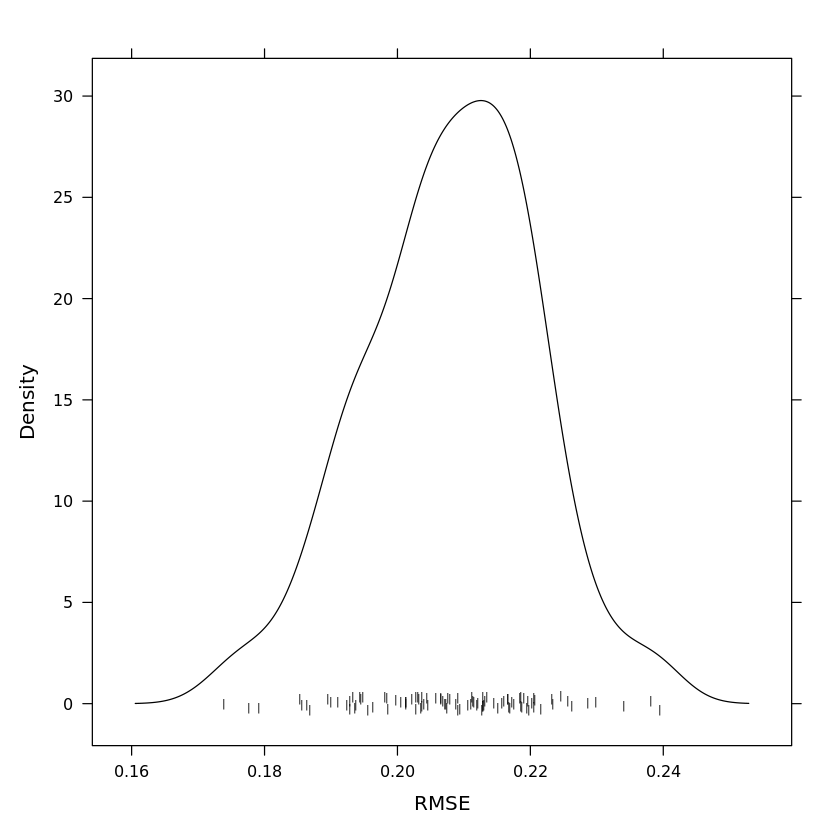

In [69]:
trellis.par.set(caretTheme())
densityplot(glmnetFit1, pch = "|")

In [70]:
summary(glmnetFit1)

            Length Class      Mode     
a0              85 -none-     numeric  
beta        203065 dgCMatrix  S4       
df              85 -none-     numeric  
dim              2 -none-     numeric  
lambda          85 -none-     numeric  
dev.ratio       85 -none-     numeric  
nulldev          1 -none-     numeric  
npasses          1 -none-     numeric  
jerr             1 -none-     numeric  
offset           1 -none-     logical  
call             6 -none-     call     
nobs             1 -none-     numeric  
lambdaOpt        1 -none-     numeric  
xNames        2389 -none-     character
problemType      1 -none-     character
tuneValue        2 data.frame list     
obsLevels        1 -none-     logical  
param            1 -none-     list     

In [72]:
predict(glmnetFit1)

2478485       5015078       1749201       3072619       4581813 
 5.617955e-02  3.473799e-02  7.530028e-02  2.900501e-02  7.499194e-03 
      2002020       1914695       5693211       2868179       1559873 
 4.059387e-02  6.841116e-02  2.126606e-02  6.044175e-02  6.211728e-02 
      2209489       1544995       5976499       1530252       5578408 
 5.488474e-02  5.398274e-02  6.707916e-02  3.330216e-02  8.237956e-02 
      1095210       1297048       1320395       3985289       4290869 
 3.939856e-02  5.358652e-02  1.074265e-02  1.126026e-01  4.506649e-02 
      2608233       3187120       4103307       3665599       1131368 
 2.800326e-02  6.847919e-02 -2.892551e-02  7.164700e-02  4.957947e-02 
      5724552       2665536       1688863       5068046       3035350 
 5.331968e-02  7.510989e-02  9.647209e-02  1.690615e-02  3.274324e-02 
      5390221       1484793       3973659       2521810       1281965 
 5.239481e-02  2.364658e-02  4.699837e-02  3.486655e-02  5.877791e-02 
      3731534       4915033       1550808       1023204       5048856 
 2.796203e-02  8.425617e-02  5.837570e-02  7.342107e-02  7.751109e-02 
      5488975       4576220       2395827       3255022       1427501 
 4.491329e-02  1.662955e-03  7.199514e-02  1.735840e-02  5.747888e-02 
      1397502       3432880       3087580       3529648       3650179 
 3.762108e-02  5.292993e-02  6.587188e-02  3.000638e-02  2.715478e-02 
      3730250       1792091       3918831       4408662       3791452 
 4.427480e-02 -7.904256e-03  7.123307e-02  2.117070e-02  7.004485e-02 
      4867589       3627821       5888995       1848752       4778067 
 5.352719e-02  8.353206e-02  7.245469e-02  5.465089e-02  3.867309e-02 
      1563027       4874561       4524456       4765303       4697193 
 3.737309e-02  9.299098e-02  3.405119e-02  4.818261e-02  3.360559e-02 
      5656402       3316104       2611600       5943319       3271494 
 1.891553e-02  5.125432e-02  3.768746e-02  4.291730e-02  7.972219e-02 
      3880699       2697830       2432291       3381377       3560197 
 7.951885e-02  2.727459e-02  4.099020e-02  2.756011e-02  8.204824e-02 
      5461095       3101640       3131055       1897725       5715364 
 3.938406e-02  3.239214e-02  2.092688e-04  4.160553e-02  1.226440e-01 
      3890207       2552140       2875037       2188651       1612328 
 2.535287e-02  2.683741e-02 -5.434038e-03  1.139605e-01  6.867665e-02 
      1645743       1644037       4628763       1300446       3667306 
 3.559721e-02 -6.001328e-03  4.941369e-02  1.077173e-01  7.051449e-02 
      4503792       3167152       1134574       5823623       2638728 
 1.053108e-01  6.549300e-02  1.003721e-03  6.051734e-02  3.494010e-02 
      4092252       1332160       2474988       3201006       4358654 
 5.554044e-03  8.402031e-02  8.473393e-02  4.983129e-02  1.838899e-02 
      3196879       1753617       5692696       4100103       4920785 
 2.592600e-02  3.795004e-02  6.838090e-02 -3.583006e-04  3.157062e-02 
      1469281       5729756       2141313       1850558       4540616 
 2.807597e-02  4.640693e-02  8.733455e-02  3.572766e-02  6.712362e-02 
      1779685       1908823       1559383       2619709       2037877 
 9.368682e-02  3.793051e-02  2.068076e-02 -5.435646e-03  3.089312e-02 
      3497975       3159630       1152836       3700638       3846611 
 1.966425e-02  6.790730e-02  1.072499e-02  4.225872e-02  7.026970e-02 
      4785634       4051832       3968974       2858260       1360277 
 6.727379e-02  1.917479e-02  1.082006e-01  1.198883e-02  6.358411e-02 
      1775299       2970125       4664393       4460867       2393568 
 5.900970e-03 -1.351881e-02  9.843315e-02  5.014072e-02  1.885452e-02 
      1958682       4232926       2245596       5405330       4219156 
 4.365746e-02  6.838585e-02  3.961516e-02  7.858353e-02  8.115383e-02 
      1191320       1726211       3947912       2051713       4174233 
 3.200092e-02  6.969807e-02  7.812235e-02  4.459254e-02  5.856746e-02 
      5632629       4384436   

In [73]:
importance1 <- varImp(glmnetFit1)

In [74]:
importance1

glmnet variable importance

  only 20 most important variables shown (out of 2389)

       Overall
OMG     100.00
CCL2     70.00
GFAP     68.67
NFX1     65.87
SEZ6L2   62.59
NTF3     58.99
PTH      58.16
ZBTB16   56.21
CRNN     54.69
LTA4H    52.86
STX7     47.61
CHGB     47.53
GIP      41.08
GP1BB    39.67
ADGRD1   38.93
CCL5     37.49
CA4      35.78
ADGRG2   35.10
CCN1     34.78
TGM2     34.65

In [75]:
tail(importance1)

,Overall
,<dbl>
A1BG,0.000000
AAMDC,0.000000
ABCA2,0.000000
ABHD14B,0.000000
ABO,0.000000
ABRAXAS2,0.000000
ACAA1,0.000000
ACADM,0.000000
ACADSB,0.000000


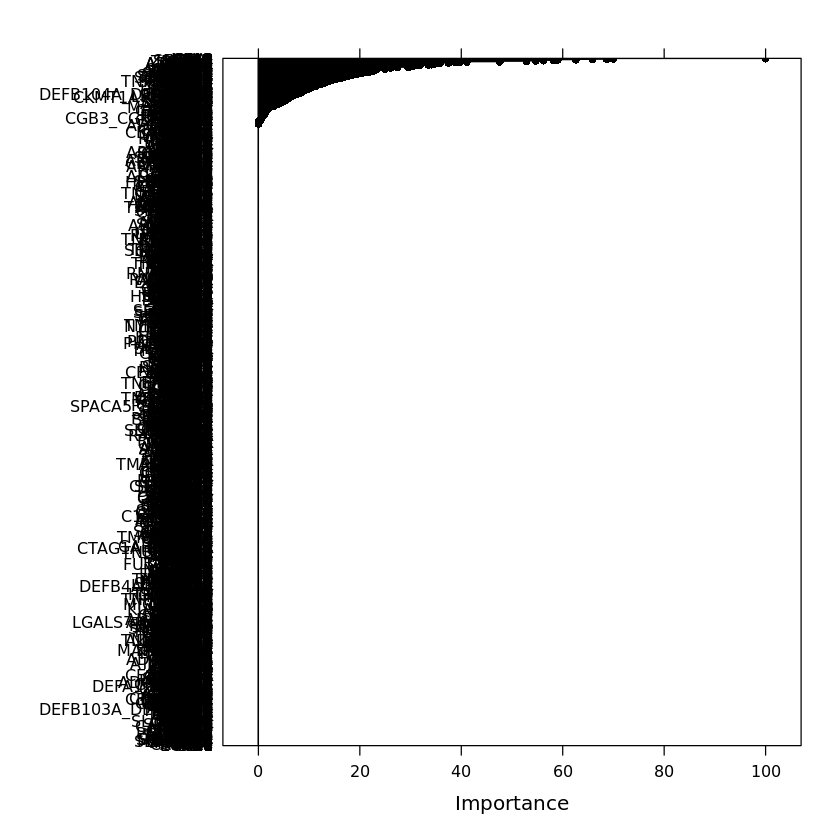

In [76]:
# Plot variable importance
plot(importance1)


In [80]:
str(importance1)

List of 3

 $ importance:'data.frame':	2389 obs. of  1 variable:

  ..$ Overall: num [1:2389] 0 0 0 0 0 0 0 0 0 0 ...

 $ model     : chr "glmnet"

 $ calledFrom: chr "varImp"

 - attr(*, "class")= chr "varImp.train"


In [81]:
head(importance1$importance)

,Overall
,<dbl>
A1BG,0
AAMDC,0
ABCA2,0
ABHD14B,0
ABO,0
ABRAXAS2,0


In [82]:
importance2 = as.data.frame(importance1$importance)
head(importance2)

,Overall
,<dbl>
A1BG,0
AAMDC,0
ABCA2,0
ABHD14B,0
ABO,0
ABRAXAS2,0


In [83]:
dim(importance2)

[1] 2389    1

In [85]:
importance2$proteins = rownames(importance2)
head(importance2)

,Overall,proteins
,<dbl>,<chr>
A1BG,0,A1BG
AAMDC,0,AAMDC
ABCA2,0,ABCA2
ABHD14B,0,ABHD14B
ABO,0,ABO
ABRAXAS2,0,ABRAXAS2


In [86]:
importance3 = importance2[importance2$Overall > 0,]
head(importance3)

,Overall,proteins
,<dbl>,<chr>
ACRBP,6.781307,ACRBP
ADGRD1,38.927748,ADGRD1
ADGRG2,35.102902,ADGRG2
AFP,1.390611,AFP
AGR3,33.513745,AGR3
AGRP,22.863582,AGRP


In [87]:
dim(importance3)

[1] 228   2

In [92]:
importance4 = importance3[order(-importance3$Overall),]
head(importance4)

,Overall,proteins
,<dbl>,<chr>
OMG,100.00000,OMG
CCL2,69.99901,CCL2
GFAP,68.66522,GFAP
NFX1,65.86673,NFX1
SEZ6L2,62.58659,SEZ6L2
NTF3,58.98718,NTF3


In [93]:
fwrite(importance4,file='md_glmnet_train_importance1.csv',sep='\t',quote=F,na='NA')

In [95]:
head(trainTransformed)

,A1BG,AAMDC,ABCA2,ABHD14B,ABO,ABRAXAS2,ACAA1,ACADM,ACADSB,ACAN,⋯,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD,Obesity,Age,Sex,PhysAct
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
2478485,0.23165139,-1.873301315,6.552117378,2.485988561,1.593362101,1.80091865,1.7974536,0.519254227,1.428199831,1.12046287,⋯,3.54607042,0.210339138,0.267663406,-0.80172492,1.239274224,0,0,60,0,1
5015078,2.08465463,-1.178840119,0.787707790,0.002274625,-1.738648489,-1.41405810,0.2745036,-0.808341400,-1.885468147,-0.94506188,⋯,-1.25673926,0.009681137,0.316437155,0.25040326,-0.316948306,0,0,40,0,1
1749201,0.02797257,0.003221484,0.002907445,-1.548979081,0.009663885,0.01096007,-1.2443574,0.002028815,0.009226025,-1.22659185,⋯,0.01561939,0.009681137,-0.004288378,-0.01302951,0.005621421,0,0,41,0,1
3072619,-0.34883489,-1.427545780,-0.303108374,-0.123351704,0.080327574,-3.58102775,1.8450458,-0.920011193,-1.762850146,-0.23901235,⋯,-2.41972806,0.087936934,0.927165788,0.05245686,0.005621421,0,0,62,0,0
4581813,0.26522854,1.966379025,1.528162470,1.249359372,0.417868023,1.93022242,1.0306401,-0.243233878,1.988211032,0.03453966,⋯,0.11273300,0.394812601,0.032817802,-0.35050547,-0.389507825,0,0,47,1,0
2002020,1.21221791,1.029993237,-0.761076583,1.391906147,-0.948384462,0.46488739,0.6638735,-0.027420867,0.875106767,1.01276040,⋯,0.82852740,0.463651755,0.502183851,0.53871651,-0.301047917,0,0,54,0,1


In [96]:
md_transformed = trainTransformed[,1:2390]
obesity_transformed = trainTransformed[,c(1:2389,2391)]
physact_transformed = trainTransformed[,c(1:2389,2394)]

In [97]:
glmnetFit1 <- train(MD ~ ., data = trainTransformed, 
                 method = "glmnet", 
                 trControl = fitControl,
                 ## This last option is actually one
                 ## for gbm() that passes through
                 verbose = T)
glmnetFit1
glmnetFit2 <- train(Obesity ~ ., data = trainTransformed, 
                 method = "glmnet", 
                 trControl = fitControl,
                 ## This last option is actually one
                 ## for gbm() that passes through
                 verbose = T)
glmnetFit2

glmnetFit3 <- train(PhysAct ~ ., data = trainTransformed, 
                 method = "glmnet", 
                 trControl = fitControl,
                 ## This last option is actually one
                 ## for gbm() that passes through
                 verbose = T)
glmnetFit3

get_imp = function(mymodel,pheno){
    imp_md1 <- varImp(mymodel)
    imp_md2 = as.data.frame(imp_md1$importance)
    imp_md2$proteins = rownames(imp_md2)
    imp_md3 = imp_md2[imp_md2$Overall > 0 | imp_md2$Overall < 0,]
    imp_md4 = imp_md3[order(-imp_md3$Overall),]
    fwrite(imp_md4,file=paste(pheno,'_glmnet_train_importance1.csv'),sep='\t',quote=F,na='NA')

}

           
get_imp(glmnetFit1,'MD')
get_imp(glmnetFit2,'Obesity')
get_imp(glmnetFit2,'PhysAct')
           
system(paste('dx upload *importance1.csv --path=/zillur/bip_bmi_smd/pheno/'))          
           

Warning message in train.default(x, y, weights = w, ...):

“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”


glmnet 

14306 samples
 2393 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 12876, 12875, 12876, 12876, 12875, 12875, ... 
Resampling results across tuning parameters:

  alpha  lambda        RMSE       Rsquared     MAE       
  0.10   2.852161e-05  0.2282741  0.009026696  0.13142729
  0.10   2.852161e-04  0.2270660  0.009371914  0.12960287
  0.10   2.852161e-03  0.2190668  0.012207064  0.11627236
  0.55   2.852161e-05  0.2278022  0.009160325  0.13071965
  0.55   2.852161e-04  0.2230270  0.010655177  0.12318110
  0.55   2.852161e-03  0.2092806  0.019838974  0.09354446
  1.00   2.852161e-05  0.2272673  0.009313979  0.12990930
  1.00   2.852161e-04  0.2199427  0.011826383  0.11785448
  1.00   2.852161e-03  0.2080990  0.023774062  0.08855487

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 0.002852161.

Warning message in train.default(x, y, weights = w, ...):

“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”


glmnet 

14306 samples
 2393 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 12875, 12876, 12876, 12875, 12875, 12875, ... 
Resampling results across tuning parameters:

  alpha  lambda        RMSE       Rsquared   MAE      
  0.10   0.0003644515  0.3345227  0.3794568  0.2641942
  0.10   0.0036445147  0.3249324  0.4028310  0.2564288
  0.10   0.0364451474  0.3121107  0.4409696  0.2477017
  0.55   0.0003644515  0.3296089  0.3911652  0.2602135
  0.55   0.0036445147  0.3122460  0.4393942  0.2470840
  0.55   0.0364451474  0.3281980  0.3924096  0.2626554
  1.00   0.0003644515  0.3258187  0.4006763  0.2571620
  1.00   0.0036445147  0.3120783  0.4404783  0.2479795
  1.00   0.0364451474  0.3392730  0.3626451  0.2722117

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 0.003644515.

Warning message in train.default(x, y, weights = w, ...):

“You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column.”


glmnet 

14306 samples
 2393 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 12875, 12875, 12876, 12875, 12875, 12876, ... 
Resampling results across tuning parameters:

  alpha  lambda        RMSE       Rsquared    MAE      
  0.10   0.0002156539  0.5028963  0.08353936  0.4334987
  0.10   0.0021565386  0.4954025  0.08956041  0.4306899
  0.10   0.0215653860  0.4681100  0.12515136  0.4279595
  0.55   0.0002156539  0.4993642  0.08628323  0.4321108
  0.55   0.0021565386  0.4775059  0.10921672  0.4265618
  0.55   0.0215653860  0.4691116  0.12114098  0.4491799
  1.00   0.0002156539  0.4964651  0.08869268  0.4310469
  1.00   0.0021565386  0.4694285  0.12272959  0.4270764
  1.00   0.0215653860  0.4744934  0.10391606  0.4602591

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.1 and lambda = 0.02156539.

In [98]:
list.files()

[1] "MD _glmnet_train_importance1.csv"                                        
 [2] "md_glmnet_train_importance1.csv"                                         
 [3] "Number_of_NA_after_removing_20p_missingness.csv"                         
 [4] "Obesity _glmnet_train_importance1.csv"                                   
 [5] "olink_data_ready1.csv"                                                   
 [6] "phenotype_bip_md_obesity_caucasian_binary_proteomics_age_sex_physact.csv"
 [7] "PhysAct _glmnet_train_importance1.csv"                                   
 [8] "proteomic_pheno_caucasian_imputed_filtered_fin1.csv"                     
 [9] "proteomic_pheno_caucasian_imputed_filtered_fin2.csv"                     
[10] "proteomic_test_transformed_data.csv"                                     
[11] "proteomic_training_transformed_data.csv"                                 
[12] "run_caret_on_rap.ipynb"

In [99]:
get_imp(glmnetFit1,'MD')
get_imp(glmnetFit2,'Obesity')
get_imp(glmnetFit2,'PhysAct')
           
system(paste('dx upload *importance1.csv --path=/zillur/bip_bmi_smd/pheno/'))          

In [100]:
length(get_imp(glmnetFit1,'MD'))

[1] 0

In [111]:
get_imp = function(mymodel,pheno){
    imp_md1 <- varImp(mymodel)
    imp_md2 = as.data.frame(imp_md1$importance)
    imp_md2$proteins = rownames(imp_md2)
    imp_md3 = imp_md2[imp_md2$Overall > 0 | imp_md2$Overall < 0,]
    imp_md4 = imp_md3[order(-imp_md3$Overall),]
    fwrite(imp_md4,file=paste(pheno,'_glmnet_train_importance1.csv'),sep='\t',quote=F,na='NA')
    return(imp_md4)

}

           
get_imp(glmnetFit1,'MD')
get_imp(glmnetFit2,'Obesity')
get_imp(glmnetFit3,'PhysAct')
system(paste('dx upload *importance1.csv --path=/zillur/bip_bmi_smd/pheno/'))          

,Overall,proteins
,<dbl>,<chr>
OMG,100.00000,OMG
CCL2,69.18520,CCL2
NFX1,65.71744,NFX1
GFAP,64.99875,GFAP
SEZ6L2,60.58029,SEZ6L2
NTF3,59.89032,NTF3
PTH,57.95455,PTH
ZBTB16,56.01620,ZBTB16
CRNN,53.82717,CRNN


,Overall,proteins
,<dbl>,<chr>
LEP,100.00000,LEP
FABP4,94.52946,FABP4
PSPN,39.05861,PSPN
THY1,38.96821,THY1
ADAMTS15,38.84301,ADAMTS15
ADM,37.00329,ADM
SSC4D,36.01413,SSC4D
OPTC,35.81517,OPTC
CD300LG,33.60300,CD300LG


,Overall,proteins
,<dbl>,<chr>
CA14,100.00000,CA14
Sex,44.49645,Sex
SMOC2,38.88481,SMOC2
MSTN,36.40462,MSTN
MEGF10,36.08129,MEGF10
PLAU,26.50692,PLAU
ADIPOQ,25.87031,ADIPOQ
NCAM1,24.68469,NCAM1
CA6,23.49750,CA6


In [107]:
head(md1)

,Overall,proteins
,<dbl>,<chr>
OMG,100.00000,OMG
CCL2,69.18520,CCL2
NFX1,65.71744,NFX1
GFAP,64.99875,GFAP
SEZ6L2,60.58029,SEZ6L2
NTF3,59.89032,NTF3


In [112]:
dim(md1)

[1] 232   2

In [113]:
dim(ob1)

[1] 452   2

In [114]:
dim(phs1)

[1] 1178    2

In [4]:
# Step 1: Make Predictions
get_predictions = function(pheno,df){
    fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated ten times
                           repeats = 10)
    
    glmnetFit1 <- train(pheno ~ ., data = trainTransformed, 
                 method = "glmnet", 
                 trControl = fitControl,
                 ## This last option is actually one
                 ## for gbm() that passes through
                 verbose = T)
    predictions <- predict(glmnetFit1, newdata = testTransformed)
    actual <- testTransformed[[pheno]]
    rsquared <- caret::R2(predictions, actual)
    rmse <- caret::RMSE(predictions, actual)
    mae <- caret::MAE(predictions, actual)
    # Print performance metrics
    print(paste("R-squared:", rsquared))
    print(paste("RMSE:", rmse))
    print(paste("MAE:", mae))
    
    # Step 3: Inspect Model Coefficients
    final_model <- glmnetFit1$finalModel
    coeff_matrix <- coef(final_model, s = "lambda.min")
    coefficients <- as.data.frame(as.matrix(coeff_matrix))
    
    # The names of the predictors
    predictor_names <- rownames(coefficients)
    
    # Create the dataframe
    results <- data.frame(
        Predictor = predictor_names,
        Coefficient = coefficients,
        R_squared = rsquared,
        RMSE = rmse, MAE = mae)
    fwrite(results,file=paste0(pheno,'_glmfit_result_summary1.csv'),sep='\t',quote = F,na = 'NA')
    return(results)
    
}


In [10]:
system(paste('dx download /zillur/bip_bmi_smd/pheno/*data.csv'))

In [11]:
list.files()

[1] "proteomic_pheno_caucasian_imputed_filtered_fin2.csv"
[2] "proteomic_training_transformed_data.csv"

In [7]:
df = fread('proteomic_pheno_caucasian_imputed_filtered_fin2.csv',data.table = F)

In [8]:
head(df)

,FID,IID,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,⋯,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD,Obesity,Age,Sex,PhysAct
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,1000045,1000045,-0.051200000,-0.18295000,0.17320,-0.14320000,-0.19310,-0.45110,1.2723000,-0.00850000,⋯,-0.00320000,-0.29650000,-0.373400,0.04050000,-0.1825000,0,0,62,1,1
2,1000246,1000246,-0.004889372,0.02543085,-0.90395,0.01916712,1.10775,-0.26705,-0.1744541,0.03415603,⋯,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741,0,0,64,0,0
3,1000624,1000624,0.287400000,-0.17145000,0.42140,-0.08530000,-0.25490,-0.74020,-2.1225000,0.06020000,⋯,-0.04580000,-0.00130000,-4.599900,0.23280000,0.1268000,0,0,61,0,1
4,1000950,1000950,-0.004889372,0.02543085,1.25435,0.01916712,-0.08715,0.38445,-0.1744541,0.03415603,⋯,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741,0,0,60,0,0
5,1002400,1002400,0.048400000,0.10905000,0.71500,0.21765000,-0.09530,0.45640,0.5247000,0.22930000,⋯,0.33565000,0.06970000,-0.511600,-0.19650000,-0.4389000,0,1,61,1,0
6,1002974,1002974,-0.059800000,-0.54855000,0.62305,0.19530000,-0.15605,-0.34820,-0.1744541,-0.44850000,⋯,0.03445000,0.03113021,-5.182600,0.03339463,0.2268741,0,0,54,1,0


In [9]:
dim(df)

[1] 28613  2917

In [12]:
rownames(df) = df$IFD
head(df)

,FID,IID,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,⋯,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,MD,Obesity,Age,Sex,PhysAct
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,1000045,1000045,-0.051200000,-0.18295000,0.17320,-0.14320000,-0.19310,-0.45110,1.2723000,-0.00850000,⋯,-0.00320000,-0.29650000,-0.373400,0.04050000,-0.1825000,0,0,62,1,1
2,1000246,1000246,-0.004889372,0.02543085,-0.90395,0.01916712,1.10775,-0.26705,-0.1744541,0.03415603,⋯,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741,0,0,64,0,0
3,1000624,1000624,0.287400000,-0.17145000,0.42140,-0.08530000,-0.25490,-0.74020,-2.1225000,0.06020000,⋯,-0.04580000,-0.00130000,-4.599900,0.23280000,0.1268000,0,0,61,0,1
4,1000950,1000950,-0.004889372,0.02543085,1.25435,0.01916712,-0.08715,0.38445,-0.1744541,0.03415603,⋯,0.09068398,0.03113021,-1.100194,0.03339463,0.2268741,0,0,60,0,0
5,1002400,1002400,0.048400000,0.10905000,0.71500,0.21765000,-0.09530,0.45640,0.5247000,0.22930000,⋯,0.33565000,0.06970000,-0.511600,-0.19650000,-0.4389000,0,1,61,1,0
6,1002974,1002974,-0.059800000,-0.54855000,0.62305,0.19530000,-0.15605,-0.34820,-0.1744541,-0.44850000,⋯,0.03445000,0.03113021,-5.182600,0.03339463,0.2268741,0,0,54,1,0
